# Project: Topic Modelling for texted mined from the Portuguese "Diário da Repúbilca" referring to laws related to the Technological Plan

<br>

## Problem: 
- Identify topics in data minined from Portuguese laws 
- Topic Modelling using Latent Dirichlet Allocation, Non-Negative Matrix Factorization and Latent Semantic Analysis + WordCloud

## Tools: 
- text mining and processing: nltk.corpus
- vectorization: TfidfVectorizer, CountVectorizer
- models: NMF, LatentDirichletAllocation, TruncatedSVD
- visualization: pyLDAvis.sklearn, WordCloud

- Use topic modelling to discovere the hidden semantic structures, abstract "topics", that occur in a collection of documents. Topic modelling identifies clusters of similar words (topics) in a mathematical framework, which allows examining a set of documents and discovering, based on the statistics of the words in each, what the topics might be and what each document's balance of topics is.
- Topic modeling can be easily compared to clustering. As in the case of clustering, the number of topics, like the number of clusters, is a hyperparameter. By doing topic modeling we build clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a certain weight.

Algorithms for topic modeling:

- LDA – Latent Dirichlet Allocation – The one we’ll be focusing in this tutorial. Its foundations are Probabilistic Graphical Models
- LSA or LSI – Latent Semantic Analysis or Latent Semantic Indexing – Uses Singular Value Decomposition (SVD) on the Document-Term Matrix. Based on Linear Algebra
- NMF – Non-Negative Matrix Factorization – Based on Linear Algebra

Here are some things all these algorithms have in common:
- The number of topics (n_topics) as a parameter. None of the algorithms can infer the number of topics in the document collection.
- All of the algorithms have as input the Document-Word Matrix (or Document-Term Matrix). DWM[i][j] = The number of occurrences of word_j in document_i
- All of them output 2 matrices: WTM (Word Topic Matrix) and TDM (Topic Document Matrix). The matrices are significantly smaller and the result of their multiplication should be as close as possible to the original DWM matrix.

In [1]:
import pandas as pd
import numpy as np

from os import listdir
from os.path import isfile, join
from tika import parser
import re
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:1140px !important; }</style>"))

import pyLDAvis.sklearn

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

print("modules loaded")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""


modules loaded


# DOCS PT

In [ ]:
ypath = './docs_pt/'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
for file in files:  
    print(file)
    raw = parser.from_file(mypath+file)
    file_name = file.split(".pdf")[0]    
    f = open(mypath+'/docs_txt/'+file_name+".txt","w+") 
    f.write(raw['content'])
    f.close()
print("done")

## 1 - Data Cleaning

### Each document is a single string at this point:
- join words that got split at the end of the line by the character "-"
- remove new line character, remove numbers, remove strange characters
- make all text lowercase
- removing short words
- for portuguese text, replace ct with t

In [2]:
documents = []
mypath = './docs_pt/docs_clean_txt/'
files = [f for f in sorted(listdir(mypath)) if isfile(join(mypath, f))]
files = [f for f in files if '20' in f]

for file in files:
    #print(file)
    file = open(mypath+file,"r") 
    documents.append(file.read())
    #break

df = pd.DataFrame({'document':documents})

#df['clean_doc'] = df['document'].str.replace("[^a-zA-Z#]", " ")

#join words that got split at the end of line by '-' 
df['clean_doc'] = df['document'].str.replace("-\n", "")

#remove new line character
df['clean_doc'] = df['clean_doc'].apply(lambda x: re.sub("\n", " ", x))

#remove numbers
df['clean_doc'] = df['clean_doc'].apply(lambda x: re.sub(r"\d+", " ", x))

#remove strange characters
df['clean_doc'] = df['clean_doc'].apply(lambda x: re.sub(r"[^\w+#]", " ", x))

#make all text lowercase
df['clean_doc'] = df['clean_doc'].apply(lambda x: x.lower())

# removing short words
df['clean_doc'] = df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

#replace ct with t
df['clean_doc'] = df['clean_doc'].apply(lambda x: re.sub("ct", "t", x))

print(df.iloc[0])

document     Resolução do Conselho de Ministros n.o 53/2001...
clean_doc    resolução conselho ministros inovação cada mai...
Name: 0, dtype: object


### Split into words, clean, merge to single string again
- remove stop-words, remove my stop-words
- for portuguese replace "os" with "o"

In [3]:
stop_words = stopwords.words('portuguese')

# tokenization
tokenized_doc = df['clean_doc'].apply(lambda x: x.split())

my_stop_words=['deste','cada','sobre','deve','assim','vista','forma','base','medida','presidente', 'portaria', 
               'outubro','membro','decreto','conselho','estado','membro','ministro','resolução', 'quadro','baseada',
              'novo', 'nova', 'central', 'serviço','presente','desde','ainda', 'seis', 'três', 'agosto',
              'seguinte','ano','data','apena','neste','nesta','número','caso','apoio', 'concurso', 'programa',
               'regional','pública', 'público','portugal','nacional','portuguesa']

#my_stop_words=['deste','cada','sobre','deve','assim','vista','forma','base','medida','presidente', 'portaria', 
#               'outubro','membro','decreto','conselho','estado','membro','ministro','resolução', 'quadro','baseada',
#              'novo', 'nova', 'central', 'serviço','presente','desde','ainda', 'seis', 'três', 'agosto',
#              'seguinte','ano','data','apena','neste','nesta','número']

tokenized_doc = tokenized_doc.apply(lambda x: [re.sub('os$', 'o', item) for item in x])
tokenized_doc = tokenized_doc.apply(lambda x: [re.sub('as$', 'a', item) for item in x])
tokenized_doc = tokenized_doc.apply(lambda x: [re.sub('pública', 'público', item) for item in x])
tokenized_doc = tokenized_doc.apply(lambda x: [re.sub('portuguesa', 'portugal', item) for item in x])

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in my_stop_words])



#steming (remove plurals)
#stemmer = PorterStemmer()
#stemmer = SnowballStemmer("portuguese")
#tokenized_doc = tokenized_doc.apply(lambda x: [stemmer.stem(item) for item in x])


# de-tokenization
detokenized_doc = []
for i in range(len(df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

df['clean_doc'] = detokenized_doc

#df.to_csv('test2.csv')
print(df.iloc[0])
print("done")

document     Resolução do Conselho de Ministros n.o 53/2001...
clean_doc    inovação fator chave competitividade vencer at...
Name: 0, dtype: object
done


## 2 - Vectorization

In [4]:
n_features = 1000

# Use tf-idf features for NMF & SVD.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, max_features=n_features, stop_words='english', smooth_idf=True)
tfidf = tfidf_vectorizer.fit_transform(df['clean_doc'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=5,  max_features=n_features, stop_words='english')
tf = tf_vectorizer.fit_transform(df['clean_doc'])
tf_feature_names = tf_vectorizer.get_feature_names()

print(tfidf.shape) # check shape of the document-term matrix

Extracting tf-idf features for NMF...
Extracting tf features for LDA...
(40, 1000)


## 3 - Topic Modelling: NMF, LatentDirichletAllocation, TruncatedSVD

- Non-negative Matrix Factorization is applied with two different objective functions: the Frobenius norm, and the generalized Kullback-Leibler divergence. The latter is equivalent to Probabilistic Latent Semantic Indexing.
  - The default parameters (n_samples / n_features / n_components) should make the example runnable in a couple of tens of seconds. In LDA, the time complexity is proportional to (n_samples * iterations).

- TruncatedSVD: Dimensionality reduction using truncated SVD (aka Latent Semantic Analysis).

In [5]:
n_samples = 2000
n_components = 3
n_top_words = 10

# Same as Latent Semantic Indexing Model
#This transformer performs linear dimensionality reduction by means of truncated singular value decomposition
#svd_model = TruncatedSVD(n_components=n_components)
svd_model_0 = TruncatedSVD(n_components=n_components, algorithm='randomized', n_iter=100, random_state=122)
svd_model_0_z = svd_model_0.fit_transform(tfidf)
#svd_Z = svd_model_0.fit_transform(tfidf)
print(svd_model_0_z.shape)  # (NO_DOCUMENTS, NO_TOPICS)

# Build a Latent Dirichlet Allocation Model
lda_model_0 = LatentDirichletAllocation(n_components=n_components, max_iter=10, learning_method='online')
lda_model_0_z = lda_model_0.fit_transform(tf)

# Fitting LDA models 
lda_model_1 = LatentDirichletAllocation(n_components=n_components,max_iter=5,learning_method='online',learning_offset=50.,random_state=0)
lda_model_1_z = lda_model_1.fit_transform(tf) 
        
# Build a Non-Negative Matrix Factorization Model
nmf_model_0 = NMF(n_components=n_components)
nmf_model_0_z = nmf_model_0.fit_transform(tfidf)

#Fitting the NMF model (Frobenius norm) with tf-idf features
nmf_model_1 = NMF(n_components=n_components, random_state=1, alpha=.1, l1_ratio=.5)
nmf_model_1_z = nmf_model_1.fit_transform(tfidf)

# Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features
nmf_model_2 = NMF(n_components=n_components, random_state=1,beta_loss='kullback-leibler',solver='mu',max_iter=1000,alpha=.1,l1_ratio=.5)
nmf_model_2_z = nmf_model_2.fit_transform(tfidf)

print("models fitted")

(40, 3)
models fitted


## 4 - print Topics

In [6]:
def create_top_words_dict(model, feature_names, n_top_words):
    top_words_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words_dict[topic_idx] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]        
    return top_words_dict

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
tf_feature_names = tf_vectorizer.get_feature_names()
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

#SVD
print("\n\n\nTopics in SVD model:")
#print_top_words(svd_model_0, tfidf_feature_names, n_top_words)
svd0_top_words = create_top_words_dict(svd_model_0, tfidf_feature_names, n_top_words)
print(svd0_top_words)

#NMF
print("\n\n\nTopics in NMF model 0:")
#print_top_words(nmf_model_0, tfidf_feature_names, n_top_words)
nmf0_top_words = create_top_words_dict(nmf_model_0, tfidf_feature_names, n_top_words)
print(nmf0_top_words)

print("\nTopics in NMF model (Frobenius norm):")
#print_top_words(nmf_model_1, tfidf_feature_names, n_top_words)
nmf1_top_words = create_top_words_dict(nmf_model_1, tfidf_feature_names, n_top_words)
print(nmf1_top_words)

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
#print_top_words(nmf_model_2, tfidf_feature_names, n_top_words)
nmf2_top_words = create_top_words_dict(nmf_model_2, tfidf_feature_names, n_top_words)
print(nmf2_top_words)

#LDA
print("\n\n\nTopics in LDA model 0:")
#print_top_words(lda_model_0, tf_feature_names, n_top_words)
lda0_top_words = create_top_words_dict(lda_model_0, tf_feature_names, n_top_words)
print(lda0_top_words)

print("\nTopics in LDA model 1:")
#print_top_words(lda_model_1, tf_feature_names, n_top_words)
lda1_top_words = create_top_words_dict(lda_model_1, tf_feature_names, n_top_words)
print(lda1_top_words)




Topics in SVD model:
{0: ['inovação', 'ciência', 'tecnologia', 'empresa', 'política', 'laboratório', 'área', 'ensino', 'investigação', 'sistema'], 1: ['laboratório', 'ciência', 'científica', 'reforma', 'superior', 'instituições', 'ensino', 'investigação', 'tecnologia', 'internacional'], 2: ['incentivo', 'projeto', 'regulamento', 'contrato', 'despesa', 'doutorado', 'regime', 'alterado', 'gestão', 'abrigo']}



Topics in NMF model 0:
{0: ['inovação', 'empreendedorismo', 'política', 'empresa', 'área', 'informação', 'tecnologia', 'ciência', 'sociedade', 'economia'], 1: ['laboratório', 'ciência', 'científica', 'superior', 'ensino', 'investigação', 'tecnologia', 'instituições', 'reforma', 'científico'], 2: ['projeto', 'incentivo', 'regulamento', 'despesa', 'fundo', 'investimento', 'gestão', 'contrato', 'alterado', 'sistema']}

Topics in NMF model (Frobenius norm):
{0: ['inovação', 'ciência', 'tecnologia', 'política', 'empresa', 'área', 'empreendedorismo', 'ensino', 'investigação', 'superi

## 5 - Calculate 2D properties

In [ ]:
pyLDAvis.enable_notebook()

print("Doing SVD0")
#panel_svd0 = pyLDAvis.sklearn.prepare(svd_model_0, tfidf, tfidf_vectorizer, mds='tsne')

words_2d_svd0 = svd_model_0.fit_transform(tfidf.T) 
df_svd0 = pd.DataFrame(columns=['x', 'y', 'word'])
df_svd0['x'], df_svd0['y'], df_svd0['word'] = words_2d_svd0[:,0], words_2d_svd0[:,1], tfidf_vectorizer.get_feature_names()

print("Doing NMF0")
panel_nmf0 = pyLDAvis.sklearn.prepare(nmf_model_0, tfidf, tfidf_vectorizer, mds='tsne')

words_2d_nmf0 = nmf_model_0.fit_transform(tfidf.T) 
df_nmf0 = pd.DataFrame(columns=['x', 'y', 'word'])
df_nmf0['x'], df_nmf0['y'], df_nmf0['word'] = words_2d_nmf0[:,0], words_2d_nmf0[:,1], tfidf_vectorizer.get_feature_names()
 
print("Doing NMF1")
panel_nmf1 = pyLDAvis.sklearn.prepare(nmf_model_1, tfidf, tfidf_vectorizer, mds='tsne')

words_2d_nmf1 = nmf_model_1.fit_transform(tfidf.T) 
df_nmf1 = pd.DataFrame(columns=['x', 'y', 'word'])
df_nmf1['x'], df_nmf1['y'], df_nmf1['word'] = words_2d_nmf1[:,0], words_2d_nmf1[:,1], tfidf_vectorizer.get_feature_names()
 
print("Doing NMF2")
panel_nmf2 = pyLDAvis.sklearn.prepare(nmf_model_2, tfidf, tfidf_vectorizer, mds='tsne')

words_2d_nmf2 = nmf_model_2.fit_transform(tfidf.T) 
df_nmf2 = pd.DataFrame(columns=['x', 'y', 'word'])
df_nmf2['x'], df_nmf2['y'], df_nmf2['word'] = words_2d_nmf2[:,0], words_2d_nmf2[:,1], tfidf_vectorizer.get_feature_names()
     
print("Doing LDA0")
panel_lda0 = pyLDAvis.sklearn.prepare(lda_model_0, tf, tf_vectorizer, mds='tsne')

words_2d_lda0 = lda_model_0.fit_transform(tf.T) 
df_lda0 = pd.DataFrame(columns=['x', 'y', 'word'])
df_lda0['x'], df_lda0['y'], df_lda0['word'] = words_2d_lda0[:,0], words_2d_lda0[:,1], tf_vectorizer.get_feature_names()

print("Doing LDA1")
panel_lda1 = pyLDAvis.sklearn.prepare(lda_model_1, tf, tf_vectorizer, mds='tsne')

words_2d_lda1 = lda_model_1.fit_transform(tf.T) 
df_lda1 = pd.DataFrame(columns=['x', 'y', 'word'])
df_lda1['x'], df_lda1['y'], df_lda1['word'] = words_2d_lda1[:,0], words_2d_lda1[:,1], tf_vectorizer.get_feature_names()

print("2D properties calculated")

### LDA 2d

In [ ]:
print("Doing LDA0")
panel_lda0 = pyLDAvis.sklearn.prepare(lda_model_0, tf, tf_vectorizer, mds='tsne', R=10)

words_2d_lda0 = lda_model_0.fit_transform(tf.T) 
df_lda0 = pd.DataFrame(columns=['x', 'y', 'word'])
df_lda0['x'], df_lda0['y'], df_lda0['word'] = words_2d_lda0[:,0], words_2d_lda0[:,1], tf_vectorizer.get_feature_names()
print("\ndone")

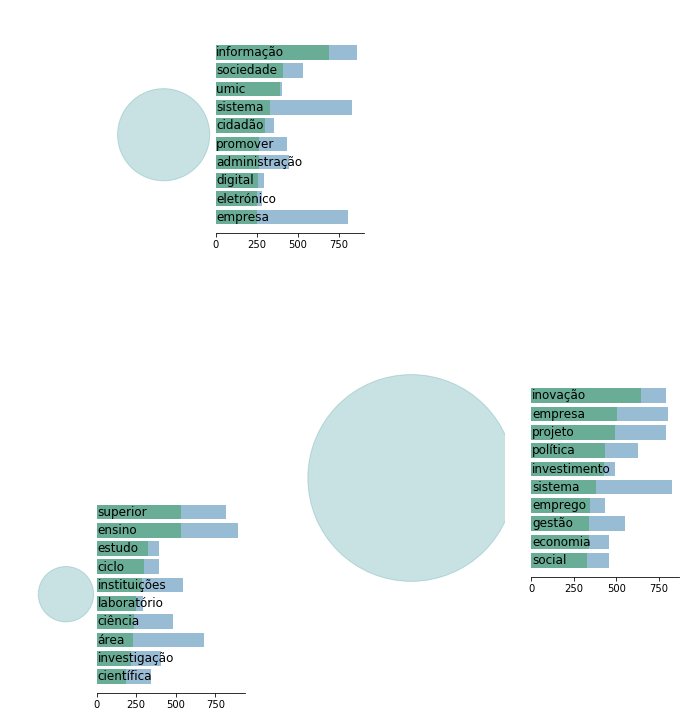

In [9]:
fig, ax = plt.subplots(figsize=(10,10))

green_blue = '#499FA4'
ax.scatter(panel_lda0.topic_coordinates['x'], panel_lda0.topic_coordinates['y'], s=panel_lda0.topic_coordinates['Freq']**2.7, 
           color=green_blue, alpha=0.3)

#increase plot area by 15%   
xlim = ax.get_xlim()  
new_xlim = [xlim[0]-(xlim[1]-xlim[0])*0.1, xlim[1]+(xlim[1]-xlim[0])*0.2]
ax.set_xlim(new_xlim)

ylim = ax.get_ylim()
new_ylim = [ylim[0]-(ylim[1]-ylim[0])*0.1, ylim[1]+(ylim[1]-ylim[0])*0.2]
ax.set_ylim(new_ylim)



#loop on topics
for idx in range (0, n_components):      
    sel = panel_lda0.topic_info['Category']=='Topic'+str(idx+1)
    df_new = panel_lda0.topic_info.loc[sel]
    sorted_df = df_new.sort_values('Freq', ascending=False)[:10].reset_index(drop=True)
    
    #write topic numbers    
    index = (panel_lda0.topic_coordinates['topics']==idx+1)    
    txt = panel_lda0.topic_coordinates['topics'].loc[index].values[0]  
    xx, yy = panel_lda0.topic_coordinates['x'][index], panel_lda0.topic_coordinates['y'][index]
    #ax.text(xx,yy, txt, fontsize=12)
       
    #bar plots  
    circle_area = panel_lda0.topic_coordinates['Freq'][index]**1.4/0.9
    x_pos = (xx.values+circle_area.values-new_xlim[0])/(new_xlim[1]-new_xlim[0]) 
    y_pos = (yy.values-new_ylim[0])/(new_ylim[1]-new_ylim[0])   
    left, bottom, width, height = [x_pos[0], y_pos[0]-0.15, 0.3, 0.3]    
    ax2 = ax.inset_axes([left, bottom, width, height],zorder=3)
    
    bar_pos = [10.-y for y in range(0,10)]    
    green = '#6AAD96'
    blue = '#99BCD5'
    ax2.barh(bar_pos, sorted_df['Total'], align='center', color=blue, alpha=1.0)
    ax2.barh(bar_pos, sorted_df['Freq'], align='center', color=green, alpha=1.0)
    
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.set_yticklabels([])
    #ax2.set_xticklabels([])
    #ax2.tick_params(left=False, right=False, top=False, bottom=False)
    ax2.tick_params(left=False, right=False, top=False, bottom=True)

    #write terms on each topic
    freq = sorted_df['Freq']/sorted_df['Freq'].max()*15.
    for ii, row in sorted_df.iterrows():             
        ax2.text(5,bar_pos[ii]-0.2, row['Term'], fontsize=12, color='#000000', weight='medium')
    


for key, spine in ax.spines.items():
        spine.set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.tick_params(left=False, right=False, top=False, bottom=False)

plt.tight_layout()
plt.savefig('./lda_bars.pdf')

### SVD 2D plot

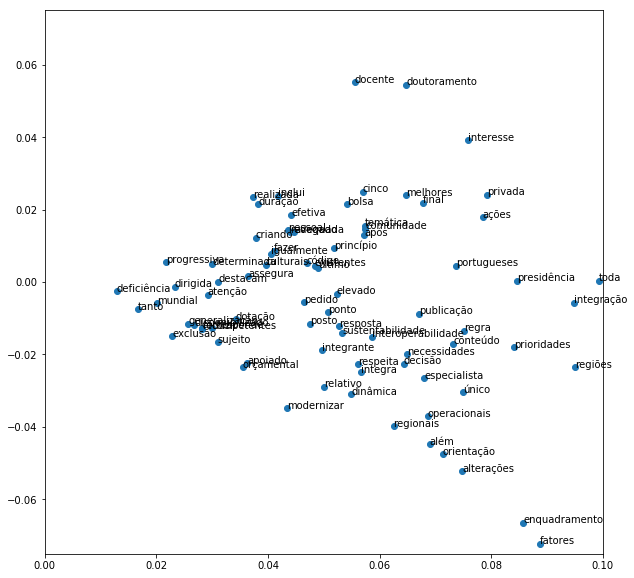

In [31]:
df_svd0_rand = df_svd0.sample(100).reset_index()
#print(df_svd0_rand)

fig, ax = plt.subplots(figsize=(10,10))
xlim = [0,0.1]
ylim = [-0.075,0.075]
ax.set_xlim(xlim), ax.set_ylim(ylim)
ax.scatter(df_svd0_rand['x'], df_svd0_rand['y'])

for i, txt in enumerate(df_svd0_rand['word']):
    #ax.annotate(txt, (df_svd0['x'][i], df_svd0['y'][i]))
    if((df_svd0_rand['x'][i]>xlim[0]) & (df_svd0_rand['x'][i]<xlim[1]) &
       (df_svd0_rand['y'][i]>ylim[0]) & (df_svd0_rand['y'][i]<ylim[1])):
        ax.text(df_svd0_rand['x'][i], df_svd0_rand['y'][i], txt)
plt.show()

## 6 - Word Cloud

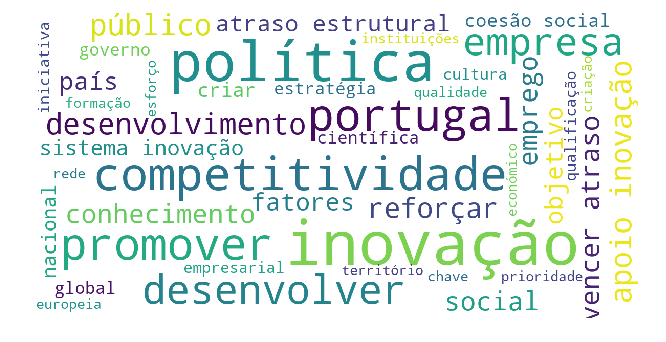

In [34]:
#from stop_words import get_stop_words
#stop_words = get_stop_words('portuguese')

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(background_color='white', max_words=100, max_font_size=40, min_font_size=8,
                          scale=3, random_state=1).generate(str(data))

    fig = plt.figure(1, figsize=(11, 11))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    wordcloud.to_file("./WordCloud.png")
           
show_wordcloud(df['clean_doc'].iloc[0])

<br>
<br>
<br>

### Portugueses Stemmer

In [246]:
from __future__ import print_function, unicode_literals
from nltk.data import load

from nltk.stem.api import StemmerI


class RSLPStemmer(StemmerI):
    """
    A stemmer for Portuguese.

        >>> from nltk.stem import RSLPStemmer
        >>> st = RSLPStemmer()
        >>> # opening lines of Erico Verissimo's "Música ao Longe"
        >>> text = '''
        ... Clarissa risca com giz no quadro-negro a paisagem que os alunos
        ... devem copiar . Uma casinha de porta e janela , em cima duma
        ... coxilha .'''
        >>> for token in text.split():
        ...     print(st.stem(token))
        clariss risc com giz no quadro-negr a pais que os alun dev copi .
        uma cas de port e janel , em cim dum coxilh .
    """

    def __init__(self):
        self._model = []

        self._model.append(self.read_rule("step0.pt"))
        self._model.append(self.read_rule("step1.pt"))
        self._model.append(self.read_rule("step2.pt"))
        self._model.append(self.read_rule("step3.pt"))
        self._model.append(self.read_rule("step4.pt"))
        self._model.append(self.read_rule("step5.pt"))
        self._model.append(self.read_rule("step6.pt"))

    def read_rule(self, filename):
        rules = load('nltk:stemmers/rslp/' + filename, format='raw').decode("utf8")
        lines = rules.split("\n")

        lines = [line for line in lines if line != ""]  # remove blank lines
        lines = [line for line in lines if line[0] != "#"]  # remove comments

        # NOTE: a simple but ugly hack to make this parser happy with double '\t's
        lines = [line.replace("\t\t", "\t") for line in lines]

        # parse rules
        rules = []
        for line in lines:
            rule = []
            tokens = line.split("\t")

            # text to be searched for at the end of the string
            rule.append(tokens[0][1:-1])  # remove quotes

            # minimum stem size to perform the replacement
            rule.append(int(tokens[1]))

            # text to be replaced into
            rule.append(tokens[2][1:-1])  # remove quotes

            # exceptions to this rule
            rule.append([token[1:-1] for token in tokens[3].split(",")])

            # append to the results
            rules.append(rule)

        return rules


    def stem(self, word):
        word = word.lower()

        # the word ends in 's'? apply rule for plural reduction
        if word[-1] == "s":
            word = self.apply_rule(word, 0)

        # the word ends in 'a'? apply rule for feminine reduction
        if word[-1] == "a":
            word = self.apply_rule(word, 1)

        # augmentative reduction
        word = self.apply_rule(word, 3)

        # adverb reduction
        word = self.apply_rule(word, 2)

        # noun reduction
        prev_word = word
        word = self.apply_rule(word, 4)
        if word == prev_word:
            # verb reduction
            prev_word = word
            word = self.apply_rule(word, 5)
            if word == prev_word:
                # vowel removal
                word = self.apply_rule(word, 6)

        return word

    def apply_rule(self, word, rule_index):
        rules = self._model[rule_index]
        for rule in rules:
            suffix_length = len(rule[0])
            if word[-suffix_length:] == rule[0]:  # if suffix matches
                if len(word) >= suffix_length + rule[1]:  # if we have minimum size
                    if word not in rule[3]:  # if not an exception
                        word = word[:-suffix_length] + rule[2]
                        break

        return word
    
st = RSLPStemmer()
print(st.stem("projectaram"))